# Stats and Public Health Part 2: Data Analysis
### Daniel Mortensen
10-Aug-2021

## Introduction  
Chicago, the last bastion of human civilization, is on the verge of collapse, as the deadly West Nile Virus (WNV) rages on without mercy. With time running out, the mayor takes a desperate chance by turning to an old data scientist with a checkered past, whose python skills might just be enough to stave off extinction. But with his daughter missing and his son coming down with the chicken pox, will the data scientist be able to focus enough to pull it off? Find out in this thrilling report. Oh, and maybe there's a dragon or something.   
  
*Task Summary*  
1. Determine the average number of mosquitoes caught each month and determine any trends.
2. Determine if mosquito species makes statistically significant impact on the likelyhood of detecting West Nile Virus?
3. Determine which factors are correlated with the number of mosquitos caught and to what extent.
4. Run a linear regression to determine how the independent variables (excluding `WNV Present`) affect the number of mosquitoes caught. 
5. Run a logistic regression to determine how the independent variables affect West Nile Virus presence.

## Methods

All data were analyzed in this Jupyter Notebook, which is running on a Python 3 kernel. The following libraries were imported for statistical analysis and data visualiztion under the given aliases:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

Data were taken from the provided `mosquito_data_part_2.csv` file, which contains tracking data for the years 2007 to 2019. This file imported into the `mosquito_original` data frame, and a copy of this data frame (`mosquito_df`) was created for data manipulation.

In [2]:
mosquito_original = pd.read_csv('./mosquito_data_part_2.csv')
mosquito_df = mosquito_original.copy()

Basic EDA was run to determine the shape of the `mosquito_df` data frame, and if this data frame contained any missing values. The data frame contains 12 columns, 18,495 rows, and there are no missing values.

In [3]:
print(mosquito_df.shape)
print(mosquito_df.isna().sum())

(18495, 12)
Year               0
Week               0
Address Block      0
Trap               0
Trap type          0
Date               0
Mosquito number    0
WNV Present        0
Species            0
Lat                0
Lon                0
Month              0
dtype: int64


## Data Management Plan  
The type of data stored in each column and the plan to deal with this data is summarized in the following list:   
- Year - Numeric --> **no change**
- Week - Numeric --> could change to cyclic variable, but we don't need weekly granularity for this report --> **drop column** 
- Address Block - Categorical --> data is repeated in `Lon` and `Lat` columns --> **drop column**
- Trap - Categorical --> Essentially synonymous with `Address Block` and `Lon` and `Lat` columns --> **drop column**
- Trap type - Categorical --> **Convert to dummy variable**
- Date - Numeric --> Already represented by `Year`, `Month` and `Week` columns --> **drop column**
- Mosquito number - Numeric --> **no change**
- WNV Present - Categorical --> **convert to binary**
- Species - Categorical --> **convert to dummy variables**
- Lat - Numeric --> **no change**
- Lon - Numeric --> **no change**
- Month - Numeric --> **change to cyclic variable**

In [4]:
# Columns identified as unnecesary are dropped from the mosquito data frame
mosquito_df.drop(columns=["Week", "Address Block", "Trap", "Date"], inplace=True)

The remaining columns will now be sorted into either a numeric or categorical data frame for further processing. The data type of each column is first idenified to ensure that all data is stored in the proper data frame.

In [5]:
print(mosquito_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Trap type        18495 non-null  object 
 2   Mosquito number  18495 non-null  int64  
 3   WNV Present      18495 non-null  object 
 4   Species          18495 non-null  object 
 5   Lat              18495 non-null  float64
 6   Lon              18495 non-null  float64
 7   Month            18495 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.1+ MB
None


In [6]:
df_numeric = mosquito_df.select_dtypes(["int64", "float64", "uint8", "int32"])
df_categorical = mosquito_df.select_dtypes("object")

The column `WNV Present` needs to be converted to a binary column. I will first determine what values are possible for this column and then determine which value to assign as 1 and which to assign as 0.

In [7]:
df_categorical["WNV Present"].value_counts()

negative    14501
positive     3994
Name: WNV Present, dtype: int64

Possible values for the `WNV Present` column include "negative" and "positive", which I will replace with "0" and "1", respectively. After this conversion is complete, I will also drop `WNV Present` from the categorical column. I will make a similar change to the `mosuito_df` data frame for later ease of analysis.

In [8]:
WNV_neg = (df_categorical['WNV Present'] == "negative")

df_numeric['WNV Present'] = np.where(WNV_neg, 0, 1)
mosquito_df['WNV Present'] = np.where(WNV_neg, 0, 1)
df_categorical.drop(columns="WNV Present", inplace=True)

<ipython-input-8-2c2f7c904644>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['WNV Present'] = np.where(WNV_neg, 0, 1)
C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


The type of trap used may have a biasing effect on wether WNV is detected or not. Therefore, the trap type will be included in the model for predicting whether WNV is present or not. To do this, dummy variables will be created for the `Trap type` column. There is not a clear best trap type to drop, so I will simply drop the first one, which is `CDC`.

In [9]:
trap_type_dummies = pd.get_dummies(df_categorical[["Trap type"]], drop_first=True)

df_numeric = pd.concat([df_numeric, trap_type_dummies], axis = 1)

# dropping Trap type from the categorical data frame for book keeping purposes.
df_categorical.drop(columns="Trap type", inplace=True)

It will also be important to understand how mosquito species plays a role in predicting the presence of WNV. Therefore, I will determing the possible species types and convert each into a dummy variable, excluding 1 species to improve analysis efficiency.

In [10]:
df_categorical.value_counts(normalize=True)*100

Species         
CULEX RESTUANS      64.157881
CULEX PIPIENS       29.662071
CULEX TERRITANS      4.958097
CULEX SALINARIUS     1.221952
dtype: float64

Species CULEX SALINARIUS is the least populus, representing only about 1% of all mosquitos caught, so I will drop the dummy variable for this species.

In [11]:
species_dummies = pd.get_dummies(df_categorical[["Species"]]).drop(columns="Species_CULEX SALINARIUS")
df_numeric = pd.concat([df_numeric, species_dummies], axis = 1)

# dropping Species from the categorical data frame for book keeping purposes.
df_categorical.drop(columns="Species", inplace=True)

Month of the year is also a possible predictor of WNV prevelance. I will model this column as a cyclic variable, as the months come and go in a cyclic pattern.  

**Note**: Even though data was collected for only 6 months, I modelled the months over 12 possible options. This improved my end model accuracy from 82.91% with 6 months to 83.04% with 12 months. A possible explenation for this result is that even though data is only collected for 6 months, patterns in the data are more readily determined when modelling the months as belonging to the real world 12 month cycle than to a simplified 6 month cycle.

In [12]:
base_angle = 2*np.pi/12

cos = np.cos(df_numeric["Month"]*base_angle)
sin = np.sin(df_numeric["Month"]*base_angle)

df_numeric["Month_cos"] = cos
df_numeric["Month_sin"] = sin

## Results and Discussion

#### *Mosquitoes per month*

The average number of mosquitos caught is plotted as function of the month of the year in the figure below. The error bars correspond to the standard error. Mosquito numbers seem to increase with increasing temperature. This is because mosquitos are cold blooded, meaning they need warmth from their environment to be active. 

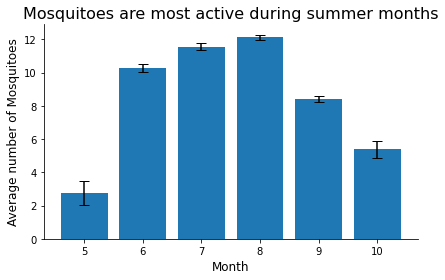

In [13]:
monthy_averages = df_numeric.groupby("Month").mean()
monthly_sem = df_numeric.groupby("Month").sem()

plt.figure()
plt.bar(monthy_averages.index.values, monthy_averages["Mosquito number"], yerr=monthly_sem["Mosquito number"], capsize=5)
plt.xlabel("Month", size=12)
plt.ylabel("Average number of Mosquitoes", size=12)
plt.title("Mosquitoes are most active during summer months", size=16)
sns.despine()
plt.tight_layout()
plt.show()

#### *Mosquito species and WNV Prevelance*

The percentage of mosquitos found to be carrying WNV as a function of species identity is plotted below, with error bars corresponding to standard error. The species *Culex Pipiens* is the most likely to carry WNV, with about 25% of mosquitoes of that species carrying the virus. In close second is *Culex Restuans* at about 21% infected.

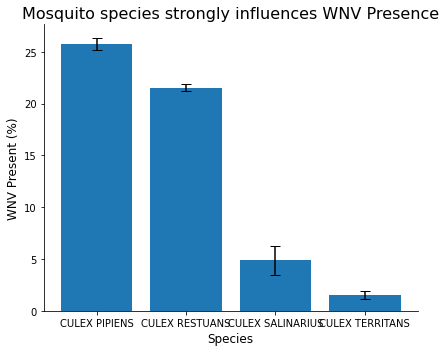

In [14]:
species_averages = mosquito_df.groupby("Species")["WNV Present"].aggregate(["mean", "std", "sem", "sum", "count"])

plt.figure(figsize=(6,5))
plt.bar(species_averages.index.values, species_averages["mean"]*100, yerr=species_averages["sem"]*100, capsize=5)
plt.xlabel("Species", size=12)
plt.ylabel("WNV Present (%)", size=12)
plt.title("Mosquito species strongly influences WNV Presence", size=16)
sns.despine()
plt.tight_layout()
plt.show()

Although the standard errors do not overlap with eachother in the plot above, statistical tests will be run to ensure that the differences observed for the above species are real and not a result of limited statistics. To first determine if there is a statistically significant difference in the percent WNV among all the species, an ANOVA test will be run. In this test, the null hypothesis (H0) is that there is no statistical difference among the species, and the alternate hypothesis (H1) is that there is a difference among the species. If a p value of less than 0.05 is obtained from this test, that will be sufficient evidence to reject the null hypothesis.

In [15]:
anova_data = {}
mosquitoes = mosquito_df["Species"].unique()

for species in mosquitoes:
    anova_data[species] = mosquito_df.loc[mosquito_df["Species"] == species, "WNV Present"]

ANOVA_p_value = stats.f_oneway(anova_data["CULEX PIPIENS"],
              anova_data["CULEX RESTUANS"],
              anova_data["CULEX SALINARIUS"],
              anova_data["CULEX TERRITANS"])[1]

print(f"The p value resulting from the ANOVA test is {ANOVA_p_value}.")
print(f"This is {0.05/ANOVA_p_value} times less than the cutoff value of 0.05.")
print("Wow!")

The p value resulting from the ANOVA test is 1.082615440825039e-67.
This is 4.618445120447943e+65 times less than the cutoff value of 0.05.
Wow!


The Results from ANOVA test indicate that there is at least one species which is significantly different from the others. I will now run a proportions z test between each species pair individually to determine which are significantly different from one another. For this test, the null hypothesis is that there is no difference between the species, and the alternate hypothesis is that there is a difference. A p value of less than 0.05 will be considered sufficient grounds for rejecting the null hypotheses for these tests.

In [16]:
mosquitoes = mosquito_df["Species"].unique()

sums = []
for key in anova_data:
    sums.append(anova_data[key].sum())

counts = []
for key in anova_data:
    counts.append(anova_data[key].count())

for n in range(4):
    for m in range(n+1, 4):
        compare_sums = []
        compare_sums.append(sums[n])
        compare_sums.append(sums[m])
        
        compare_counts = []
        compare_counts.append(counts[n])
        compare_counts.append(counts[m])
        
        print("p value (" + mosquitoes[n] + " vs " + mosquitoes[m] + "):")
        print(proportions_ztest(compare_sums, compare_counts)[1])
        print("\n")

p value (CULEX RESTUANS vs CULEX TERRITANS):
4.149911157085309e-48


p value (CULEX RESTUANS vs CULEX SALINARIUS):
1.2461111009600203e-09


p value (CULEX RESTUANS vs CULEX PIPIENS):
1.0019767964463832e-09


p value (CULEX TERRITANS vs CULEX SALINARIUS):
0.0021029008936009263


p value (CULEX TERRITANS vs CULEX PIPIENS):
8.231567115719057e-60


p value (CULEX SALINARIUS vs CULEX PIPIENS):
1.164688112052138e-12




Values significantly less than 0.05 where obtained for each comparison, indicating that there is a statistically significant difference in the carrier rates among all the different mosquito species.

#### *Factors impacting the number of mosquitoes caught*

In order to determine which factors affect the numbers of mosquitos present, I will determine the linear correlation between `Mosquito number` and all other variables using the `corr()` function.

In [17]:
correlation = df_numeric.corr()
correlation = correlation["Mosquito number"]
correlation.pop("Mosquito number")
correlation = correlation.sort_values(ascending=False)
correlation

WNV Present                0.408034
Year                       0.129326
Trap type_SENTINEL         0.108575
Lat                        0.096820
Species_CULEX RESTUANS     0.070999
Species_CULEX PIPIENS      0.014730
Month_sin                  0.005443
Trap type_OVI             -0.005392
Month                     -0.040426
Month_cos                 -0.064980
Trap type_GRAVID          -0.138275
Species_CULEX TERRITANS   -0.150962
Lon                       -0.151421
Name: Mosquito number, dtype: float64

These columns have a positive correlation with `Mosquito number`:  
- WNV Present
- Year
- Trap type_SENTINEL
- Lat
- Species_CULEX RESTUANS
- Species_CULEX PIPIENS
- Month_sin  

These columns have a negative correlation with `Mosquito number`:
- Trap type_OVI
- Month
- Month_cos
- Trap type_GRAVID
- Species_CULEX TERRITANS
- Lon

The strongest correlation is with `WNV Present`, which only has a correlation value of about 0.41, indicating that none of these values has a strong linear correlation with `Mosquito number`. It should be noted that in this calculation, only a linear correlation is considered. Correlations with other function types, such as logarithems, may be higher.

#### *Linear Regression comparison of Variables with the Number of Mosquitoes Caught*

For this analysis, the number of mosquitos caught (`Mosquito number`) will compared with all of the other independent variables except `WNV Present`, as the presence of WNV actually has a dependence on `Mosquito number`. The correlation between the independent variable will first be examined for multicoliniarity. Variables with correlations greater than 0.5 or less than -0.5 will be considered for removal from the model.

In [18]:
x_vals = df_numeric[["Year", "Month", "Lat", "Lon", "Month_cos", "Month_sin"]]
y_vals = df_numeric["Mosquito number"]

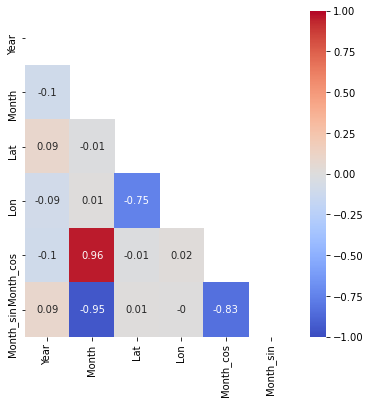

In [19]:
df_corr = x_vals.corr()

plt.figure(figsize=(6,6))
sns.heatmap(df_corr.round(2),  vmin=-1, vmax=1, cmap="coolwarm", annot=True, mask=np.triu(df_corr))
plt.show()

There appears to be a strong correlation between the `Lon` and `Lat`. However, there appears to be no clear reason for removing either from the analyses. There is also a strong correlation between `Month` and `Month_cos` and `Month_sin`. These are repeating information; therefore, `Month` will be dropped from the analyses. `Month_cos` and `Month_sin` also have a strong correlation. This is because they are related information. Neither of these columns will be dropped.  
  
The linear model of our data can now be created by dropping the `Month` column and fitting the data with the `statsmodels.api`.

In [20]:
x_vals_const = sm.add_constant(x_vals.drop(columns="Month"))

mosquito_lr = sm.OLS(y_vals, x_vals_const)
mosquito_lr = mosquito_lr.fit()
display(mosquito_lr.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     183.0
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          7.82e-191
Time:                        19:53:43   Log-Likelihood:                -73899.
No. Observations:               18495   AIC:                         1.478e+05
Df Residuals:                   18489   BIC:                         1.479e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2717.8152    110.945    -24.497      0.000   -2935.278   -2500.352
Year           0.4064      0.026     15.497      0.000       0.355       0.458
Lat           -4.9894      1.267     -3.939      0.000      -7.472      -2.507
Lon          -24.0718      1.533    -15.705      0.000     -27.076     -21.068
Month_cos     -6.8198      0.489    -13.936      0.000      -7.779      -5.861
Month_sin     -6.2324      0.520    -11.980      0.000      -7.252      -5.213
==============================================================================
Omnibus:                     5024.504   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10668.046
Skew:                           1.622   Prob(JB):                         0.00
Kurtosis:                       4.820   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An r squared value of less than 0.05 is obtained, possibly indicating that our data is poorly fit using linear regression. To confirm this, the number of mosquitos predicted to be in each trap is plotted as a function of the actual number of mosquitos in the trap in the left column of the figure below. The residuals associated with this plot are also shown in the right panel as a function of the actual number of mosquitoes in each trap. There appears to be no relationship between predicted and actual number of mosquitoes caught, and the residual plot shows a strange diagnol behaviour for its enourmous residual values. Clearly, linear fitting is not the way to analyze these data.

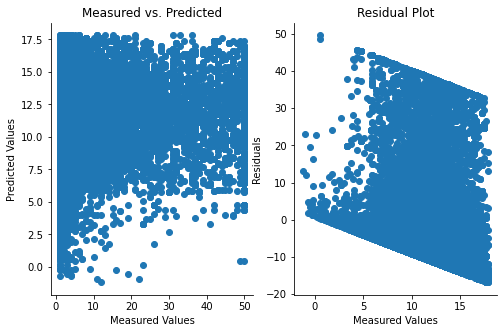

In [21]:
# soft predictions, the probability of getting the deposit
y_pred = mosquito_lr.predict(x_vals_const)

plt.subplots(2, figsize=(8,5))
plt.subplot(1,2,1)
plt.scatter(y_vals, y_pred)
plt.xlabel("Measured Values")
plt.ylabel("Predicted Values")
plt.title("Measured vs. Predicted")
plt.subplot(1,2,2)
plt.scatter(mosquito_lr.fittedvalues, mosquito_lr.resid)
plt.xlabel("Measured Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
sns.despine()
plt.show()


Improving the linear model was attempted by removing columns with excesive colinearity, including the `Lat` and `Month_sin` columns. However, as can be seen below, this change did not improve the linear model. The r squared value decreased to 0.039 and there is no clear improvements to predictive power of the model or the resulting residuals. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     249.5
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          9.31e-159
Time:                        19:53:43   Log-Likelihood:                -73978.
No. Observations:               18495   AIC:                         1.480e+05
Df Residuals:                   18491   BIC:                         1.480e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2533.2062     99.826    -25.376      0.000   -2728.873   -2337.539
Year           0.4010      0.026     15.235      0.000       0.349       0.453
Lon          -19.7895      1.023    -19.348      0.000     -21.794     -17.785
Month_cos     -1.9387      0.272     -7.126      0.000      -2.472      -1.405
==============================================================================
Omnibus:                     5098.704   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10941.515
Skew:                           1.640   Prob(JB):                         0.00
Kurtosis:                       4.854   Cond. No.                     2.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

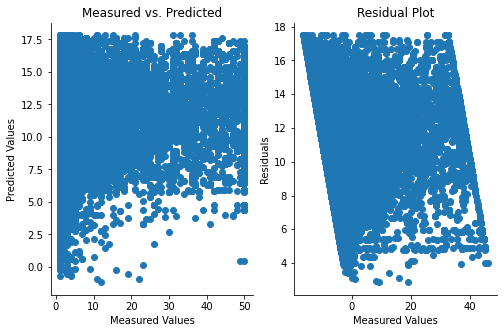

In [22]:
x_vals = df_numeric[["Year", "Lon", "Month_cos"]]
y_vals = df_numeric["Mosquito number"]

x_vals_const = sm.add_constant(x_vals)
mosquito_lr = sm.OLS(y_vals, x_vals_const)
mosquito_lr = mosquito_lr.fit()
display(mosquito_lr.summary())

plt.subplots(2, figsize=(8,5))
plt.subplot(1,2,1)
plt.scatter(y_vals, y_pred)
plt.xlabel("Measured Values")
plt.ylabel("Predicted Values")
plt.title("Measured vs. Predicted")
plt.subplot(1,2,2)
plt.scatter(mosquito_lr.resid, mosquito_lr.fittedvalues)
plt.xlabel("Measured Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
sns.despine()
plt.show()

#### *Logistic predictions of WNV Presence*

All of the independent variables are compared to the presence of WNV using a logistical regression model, as shown below.

In [23]:
x_vals_logis = df_numeric.drop(columns=["WNV Present", "Month"])
x_vals_logis_const = sm.add_constant(x_vals_logis)
y_vals_logis = df_numeric["WNV Present"]

WNV_logistic_r = sm.Logit(y_vals_logis, x_vals_logis_const)
WNV_logistic_r = WNV_logistic_r.fit()
display(WNV_logistic_r.summary())

         Current function value: 0.370386
         Iterations: 35


C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18482
Method:                           MLE   Df Model:                           12
Date:                Mon, 09 Aug 2021   Pseudo R-squ.:                  0.2901
Time:                        19:53:43   Log-Likelihood:                -6850.3
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -574.0507     26.244    -21.874      0.000    -625.488    -522.614
Year                        0.1237      0.007     17.707      0.000       0.110       0.137
Mosquito number             0.0680      0.002     43.020      0.000       0.065       0.071
Lat                        -0.7723      0.297     -2.604      0.009      -1.353      -0.191
Lon                        -3.9552      0.349    -11.334      0.000      -4.639      -3.271
Trap type_GRAVID            0.2650      0.138      1.926      0.054      -0.005       0.535
Trap type_OVI             -11.1220   6682.078     -0.002      0.999   -1.31e+04    1.31e+04
Trap type_SENTINEL         -0.2750      0.223     -1.231      0.218      -0.713       0.163
Species_CULEX PIPIENS       1.0406      0.327      3.181      0.001       0.400       1.682
Species_CULEX RESTUANS      0.8890      0.327      2.722      0.006       0.249       1.529
Species_CULEX TERRITANS    -1.3407      0.424     -3.163      0.002      -2.171      -0.510
Month_cos                  -3.3889      0.149    -22.700      0.000      -3.681      -3.096
Month_sin                  -7.0518      0.218    -32.282      0.000      -7.480      -6.624
===========================================================================================
"""

This model returned p values of less than 0.05 for all variables except the trap types. The training data will now be run against the model to get a rough estimate of the model's accuracy.

In [24]:
# soft predictions, the probability of getting the deposit
y_vals_predicted = WNV_logistic_r.predict(x_vals_logis_const)
y_vals_bool = np.where(y_vals_predicted >= 0.5, 1, 0)
num_correct = (y_vals_bool == y_vals_logis).sum()
accuracy = num_correct / y_pred.shape[0] * 100
print(f"The model accuracy is {round(accuracy,2)}%")

The model accuracy is 83.04%


| Model | Accuracy |
| --- | --- |
| Model v1 | 83.04% |

An accuracy of 83.04% is obtained for the first version of the model. In order to attempt to improve the model, all of the trap types will be dropped from the model.

In [25]:
x_vals_logis = df_numeric.drop(columns=["WNV Present", "Month", "Trap type_GRAVID", "Trap type_OVI", "Trap type_SENTINEL"])
x_vals_logis_const = sm.add_constant(x_vals_logis)
y_vals_logis = df_numeric["WNV Present"]

WNV_logistic_r = sm.Logit(y_vals_logis, x_vals_logis_const)
WNV_logistic_r = WNV_logistic_r.fit()

y_proba = WNV_logistic_r.predict(x_vals_logis_const)
y_pred = np.where(y_proba >= 0.5, 1, 0)
num_correct = (y_pred == y_vals_logis).sum()
accuracy = num_correct / y_pred.shape[0] * 100
print(f"The model accuracy is {round(accuracy,2)}%")

Optimization terminated successfully.
         Current function value: 0.370737
         Iterations 9
The model accuracy is 82.92%


| Model | Accuracy |
| --- | --- |
| Model v1 | 83.04% |
| Model v2 | 82.92% |

A slight loss in accuracy is observed when the trap types are removed. Thus, trap types will be retained in the model.  
The longitude and latitude have a high degree of clinearity. Therefore, I will also try dropping the longitude and latitude from the model in seperate experiments, denoted as models 3a and 3b, respectively.

In [26]:
x_vals_logis = df_numeric.drop(columns=["WNV Present", "Month", "Lon"])
x_vals_logis_const = sm.add_constant(x_vals_logis)
y_vals_logis = df_numeric["WNV Present"]

WNV_logistic_r = sm.Logit(y_vals_logis, x_vals_logis_const)
WNV_logistic_r = WNV_logistic_r.fit()

y_proba = WNV_logistic_r.predict(x_vals_logis_const)
y_pred = np.where(y_proba >= 0.5, 1, 0)
num_correct = (y_pred == y_vals_logis).sum()
accuracy = num_correct / y_pred.shape[0] * 100
print(f"The model accuracy w/o Lon is {round(accuracy,2)}%")

x_vals_logis = df_numeric.drop(columns=["WNV Present", "Month", "Lat"])
x_vals_logis_const = sm.add_constant(x_vals_logis)
y_vals_logis = df_numeric["WNV Present"]

WNV_logistic_r = sm.Logit(y_vals_logis, x_vals_logis_const)
WNV_logistic_r = WNV_logistic_r.fit()

y_proba = WNV_logistic_r.predict(x_vals_logis_const)
y_pred = np.where(y_proba >= 0.5, 1, 0)
num_correct = (y_pred == y_vals_logis).sum()
accuracy = num_correct / y_pred.shape[0] * 100
print(f"The model accuracy w/o Lat is {round(accuracy,2)}%")

         Current function value: 0.373923
         Iterations: 35
The model accuracy w/o Lon is 82.68%
         Current function value: 0.370570
         Iterations: 35
The model accuracy w/o Lat is 82.95%


C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| Model | Accuracy |
| --- | --- |
| Model v1 | 83.04% |
| Model v2 | 82.92% |
| Model v3a | 82.68% |
| Model v3b | 82.95% |

Removing the longitude and latitude also failed to improve the model. Thus, the 1st version of the model is the most accurate version of the model produced and will be used for predicting the likelyhood of finding WNV.